# I2T and T2I search

In [20]:
%matplotlib inline
import os.path as op


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from nltk.corpus import stopwords
import numpy as np
from pycocotools.coco import COCO

from retrieval_pipelines import absolute_coco_path, tag_to_image_search, image_to_tag_search, most_common_tags
from text_processing import create_caption_dataframe

### Coco API loading

In [2]:
data_dir = "dataset"
data_type = "train2014"
ann_file = op.join(
    data_dir, "annotations", "instances_{0}.json".format(data_type))
coco = COCO(ann_file)

loading annotations into memory...
Done (t=13.15s)
creating index...
index created!


### Pre-calculated features loading

In [3]:
W_visual = np.load("W1.npy")
W_text = np.load("W2.npy")
V = np.load("V.npy")
T = np.load("T.npy")
img_ids = np.load("visual_img_ids.npy")
W_text = W_text.T
W_visual = W_visual.T

## Tag to image search

In [4]:
database_images = W_visual.dot(V.T)
database_images = database_images.T

In [5]:
tag = "sport"
feature_path = "{0}_features.npy".format(tag)

In [6]:
if not op.exists(feature_path):
    import gensim
    
    from text_processing import sentence2vec
    
    print('\nLoading word2vec model ...')
    model_path = op.join('models', 'GoogleNews-vectors-negative300.bin')
    model = gensim.models.Word2Vec.load_word2vec_format(model_path, binary=True)
    tag_features = sentence2vec(tag, model)
    del model
    np.save("{0}_features".format(tag), tag_features)

In [7]:
tag_features = np.load(feature_path)

In [8]:
retrieved_img_ids = tag_to_image_search(tag_features, W_text, database_images, img_ids, coco, n_images=10)
img_paths = [absolute_coco_path(int(img_id), coco) for img_id in retrieved_img_ids]

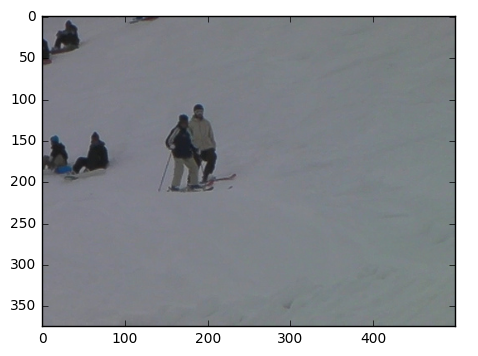

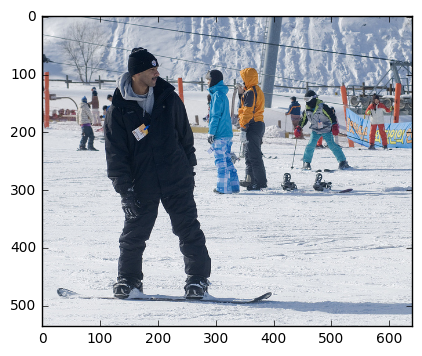

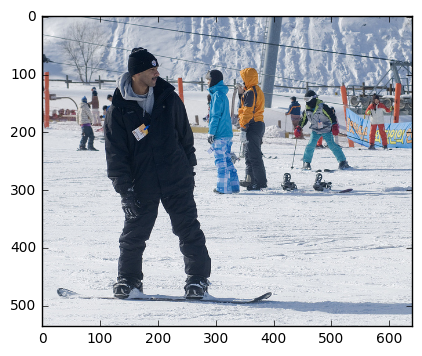

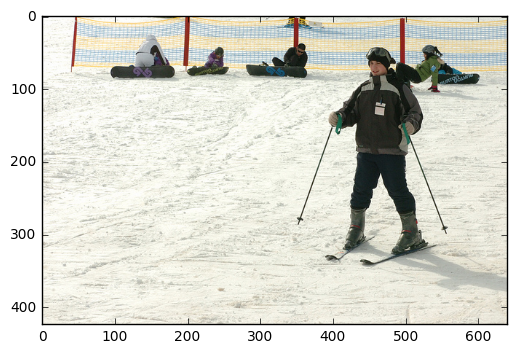

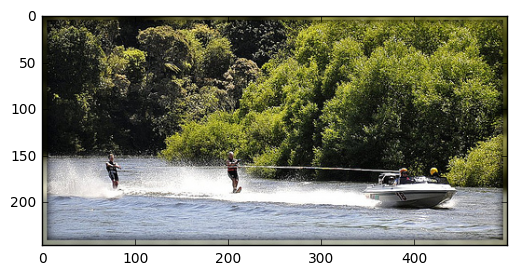

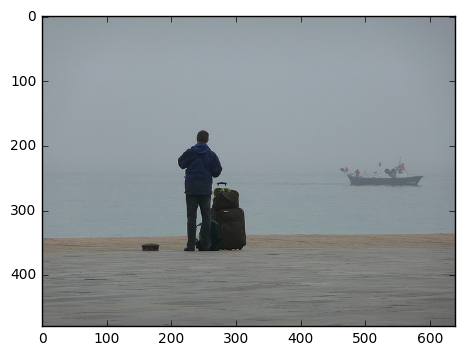

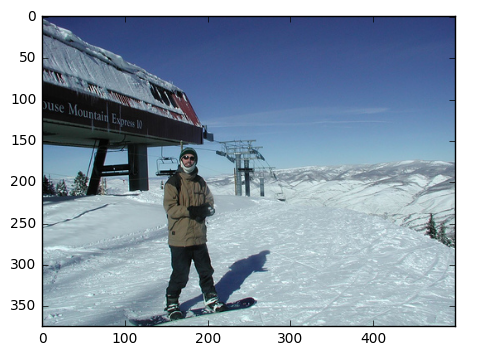

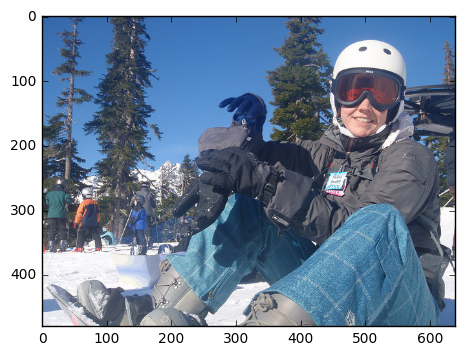

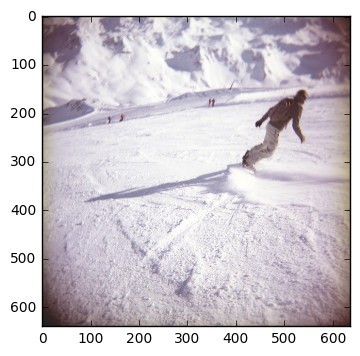

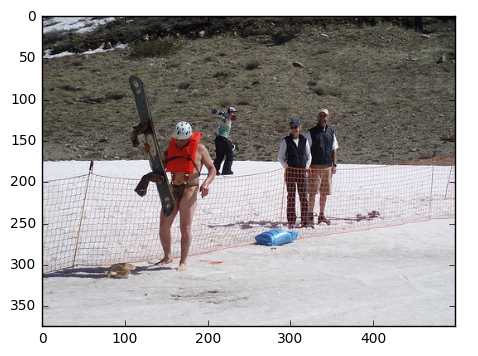

In [9]:
for im_idx, img_path in enumerate(img_paths):
    plt.figure(im_idx)
    img = mpimg.imread(img_path)
    imgplot = plt.imshow(img)

## Image to tag search

In [10]:
database_captions = W_text.dot(T.T)
database_captions = database_captions.T

In [11]:
image_name = "boat.jpg"
image_path = op.join(data_dir, "test", image_name)
visual_feature_path = "{0}_visual_features.npy".format(image_name.split(".")[0])

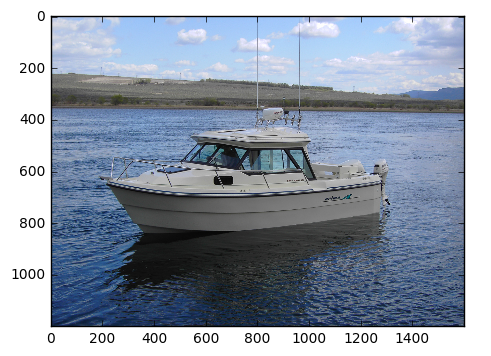

In [12]:
plt.figure()
plt.imshow(mpimg.imread(image_path))

In [13]:
if not op.exists(visual_feature_path):
    from keras.applications import vgg19
    from keras.optimizers import SGD
    
    from image_processing import process_image
    from vgg import compute_nn_features
    
    img_mat = process_image(image_path)
    net = vgg19.VGG19()
    sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    net.compile(optimizer=sgd, loss='categorical_crossentropy')
    visual_features = compute_nn_features([img_mat], net)
    np.save("{0}_visual_features".format(image_name.split(".")[0]), visual_features)
    del net
    del sgd

In [14]:
visual_features = np.load(visual_feature_path)
visual_features = np.reshape(visual_features, (W_visual.shape[1]))

In [15]:
n_tags = 4
annotations = image_to_tag_search(visual_features.T, W_visual, database_captions, img_ids, coco, n_tags=n_tags, expanding_factor=4)

In [16]:
stops = set(stopwords.words('english'))

In [17]:
most_common_tags(annotations, n_tags, stops)

[('boat', 39), ('giraffe', 35), ('giraffes', 34), ('people', 33)]

In [18]:
img_id = retrieved_img_ids[0]
coco.loadImgs(int(img_id))[0]

{'coco_url': 'http://mscoco.org/images/355111',
 'date_captured': '2013-11-20 06:18:24',
 'file_name': 'COCO_train2014_000000355111.jpg',
 'flickr_url': 'http://farm4.staticflickr.com/3328/3625293868_53b11f3e08_z.jpg',
 'height': 375,
 'id': 355111,
 'license': 3,
 'width': 500}

## Precision recall (PR) curve for T2I
Given that the caption evaluation is not available in the Python MS Coco API, we chose to check whether an image was correctly returned by seeing if the tag was present in the description.

In [21]:
df_caption = create_caption_dataframe()

In [22]:
tags = "giraffe snowboard boat snow water".split()
features_paths = ["{0}_features.npy".format(tag) for tag in tags]

We do a pre-processing of all the tags in order not to have to run the forward pass everytime

In [23]:
for tag_idx, tag in enumerate(tags):
    import gensim
    from text_processing import sentence2vec
    if not op.exists(features_paths[tag_idx]):
        try:
            model
        except NameError:
            print("Loading Word2Vec model")
            model_path = op.join('models', 'GoogleNews-vectors-negative300.bin')
            model = gensim.models.Word2Vec.load_word2vec_format(model_path, binary=True)
        finally:
            tag_features = sentence2vec(tag, model)
            np.save("{0}_features".format(tag), tag_features)
            del tag_features
try:
    del model
except NameError:
    print("its all good man")

its all good man


To calculate the recall, we need to first compute the number of images for this tag

In [24]:
counter = dict()
for tag in tags:
    counter[tag] = 0
for caption in df_caption["caption"]:
    for tag in tags:
        counter[tag] += int(tag in caption)

In [25]:
max_n_images = 1000
precisions = dict()
recalls = dict()
for tag in tags:
    precisions[tag] = np.zeros(max_n_images)
    recalls[tag] = np.zeros(max_n_images)

In [26]:
for tag_idx, tag in enumerate(tags):
    tag_features = np.load(features_paths[tag_idx])
    for n_images in range(1, max_n_images+1):
        retrieved_img_ids = tag_to_image_search(tag_features, W_text, database_images, img_ids, coco, n_images=n_images)
        correct_number = 0
        for caption in df_caption.loc[retrieved_img_ids]["caption"]:
            correct_number += int(tag in caption)
        precisions[tag][n_images - 1] = correct_number*100 / n_images
        recalls[tag][n_images - 1] = correct_number*100 / counter[tag]

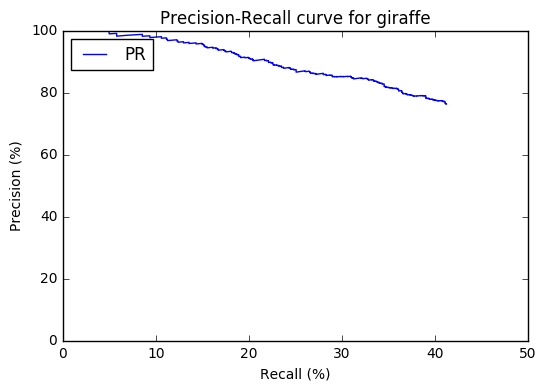

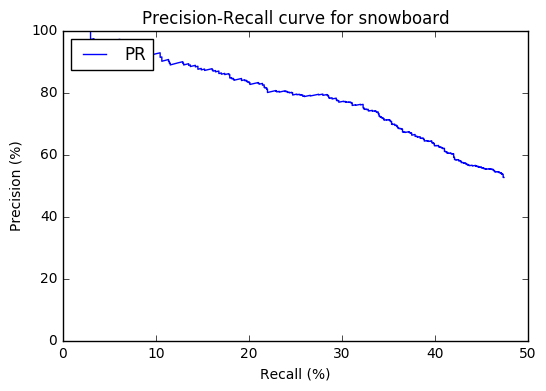

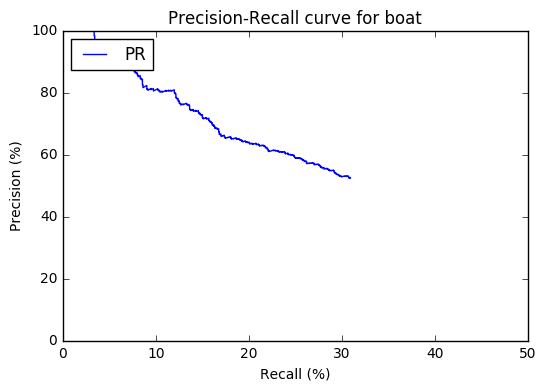

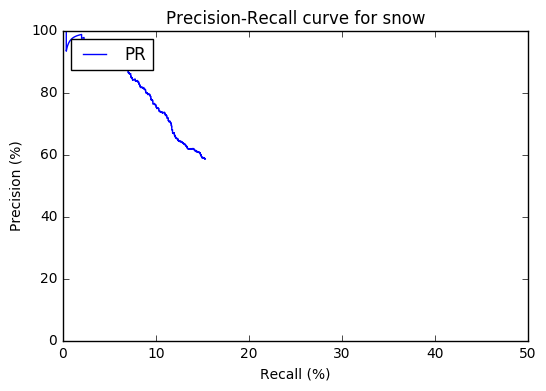

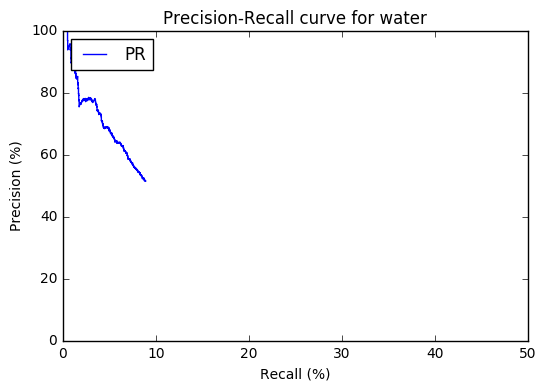

In [30]:
for tag_idx, tag in enumerate(tags):
    precision = precisions[tag]
    recall = recalls[tag]
    plt.figure(tag_idx)
    plt.title("Precision-Recall curve for {0}".format(tag))
    plt.plot(recall, precision, label="PR")
    plt.ylabel("Precision (%)")
    plt.xlabel("Recall (%)")
    plt.legend(loc=2)
    plt.axis([0, 50, 0, 100])
    plt.show()